<a href="https://colab.research.google.com/github/KnzMcn/Monkeypox-Using-Autoencoders/blob/main/Autoencoders_Attempt2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Another attempt at building an autoencoder as a classifier

# Import the libraries

In [1]:
#if image_dataset_loader is not available uncomment the line below
!pip install image-dataset-loader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import image_dataset_loader

import keras
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, Adadelta, SGD, Adam
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

from google.colab import drive
import zipfile
import os
from PIL import Image

# Import the dataset

In [ ]:
#the commented code below only works on local source
#(X_train, y_train), (X_test, y_test), (X_val, y_val) = image_dataset_loader.load("C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1", ['Train', 'Test', 'Val'])

In [3]:
#using Gdrive to import the dataset into Google Colab
#will ask for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip the desired folder and extract the contents into the tmp folder
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/3rd year/Machine Learning/Learning Evidence/Fold1.zip', 'r') #Opens the file in read mode
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
#create a new directory for storing the resized images
os.mkdir('/tmp/Fold1/Resized')

In [ ]:
#resize the image for faster processing
main_directory = '/tmp/Fold1/Fold1/'
newpath = '/tmp/Fold1/Resized/'

for subdir, dirs, files in os.walk(main_directory):
  for file in files:
    filepath = os.path.join(subdir, file)
    outpath = os.path.join(newpath, file)

    if filepath.endswith('.jpg'):
      im = Image.open(filepath)
      imResize = im.resize((100, 100), Image.ANTIALIAS)
      imResize.save(outpath + '_resized.jpg', 'JPEG', quality=90)

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = image_dataset_loader.load('/tmp/Fold1/Resized', ['Train', 'Test', 'Val'])

FileNotFoundError: ignored

In [ ]:
#print the shape of each set
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape))
print("\nX_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("\nX_val shape: {}\ny_val shape: {}".format(X_val.shape, y_val.shape))

X_train shape: (2142, 224, 224, 3)
y_train shape: (2142,)

X_test shape: (45, 224, 224, 3)
y_test shape: (45,)

X_val shape: (420, 224, 224, 3)
y_val shape: (420,)


#resize the image for faster processing
def process_image(file, source_dir, target_dir):
  source_path = os.path.join(source_dir, file)
  open_image = Image.open(source_path)
  image = open_image.resize((100, 100))
  target_path = source_path.replace(source_dir, target_dir)
  if not os.path.exists(os.path.dirname(target_path)):
    try:
      os.makedirs(os.path.dirname(target_path))
    except:
      pass
  image.save(target_path)
  os.remove(source_path)

from posix import read
def resize_image(src_img, size=(100, 100)):
  src_img.thumbnail(size, Image.ANTIALIAS)
  new_image = Image.new("RGB", size)
  new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  return new_image

train_folder = '/tmp/Fold1/Fold1/Train/'
train_image_files = os.listdir(train_folder)

X_train = []
size = (100, 100)

for file_idx in range(len(train_image_files)):
  img = Image.open(os.path.join(train_folder, train_image_files[file_idx]))
  resized_img = np.array(resize_image(img, size))
  X_train.append(resized_img)

In [ ]:
#print the shape of each set
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape))
print("\nX_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("\nX_val shape: {}\ny_val shape: {}".format(X_val.shape, y_val.shape))

X_train shape: (2142, 224, 224, 3)
y_train shape: (2142,)

X_test shape: (45, 224, 224, 3)
y_test shape: (45,)

X_val shape: (420, 224, 224, 3)
y_val shape: (420,)


In [ ]:
#create dictionary of target classes
label_dict = {
    0: 'Monkeypox',
    1: 'Others'
}

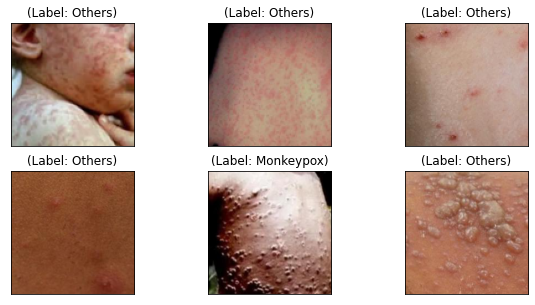

In [ ]:
#display images
plt.figure(figsize = [10, 5])

n = 3 #how many images to display
for i in range(n):
    #training images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[i].reshape(100, 100, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = y_train[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")

    #testing images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = y_test[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")
plt.show()

In [ ]:
#print the labels for each set
print("Labels for y_train: {}".format(y_train[:5]))
print("Labels for y_test: {}".format(y_test[:5]))
print("Labels for y_val: {}".format(y_val[:5]))

Labels for y_train: [1 1 1 1 1]
Labels for y_test: [1 0 1 1 1]
Labels for y_val: [1 0 1 0 1]


# Preprocessing

In [ ]:
#cleaning and reshaping the data
X_train = X_train.astype('float32') / 255
X_train = np.reshape(X_train, (len(X_train), 224, 224, 3))
X_test = X_test.astype('float32') / 255
X_test = np.reshape(X_test, (len(X_test), 224, 224, 3))
X_val = X_val.astype('float32') / 255
X_val = np.reshape(X_val, (len(X_val), 224, 224, 3))

# Convolutional Autoencoder

In [ ]:
#state the hyperparameters of the model
batch_size = 200
epochs = 20
inChannel = 3
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [ ]:
#creating the encoder function
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding ='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [ ]:
#creating the decoder function
def decoder(conv4):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [ ]:
#specifying the loss type
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss = 'mean_squared_error', optimizer = RMSprop())

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0   

# Train the model

In [ ]:
autoencoder_train = autoencoder.fit(X_train,
                                    y_train, 
                                    batch_size = batch_size, 
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = (X_val, y_val))

Epoch 1/20
34/34 [==============================] - 2730s 80s/step - loss: 0.2565 - val_loss: 0.2458
Epoch 2/20
10/34 [=======>......................] - ETA: 31:01 - loss: 0.2508

KeyboardInterrupt: ignored

In [ ]:
#plot the loss between training and validation data
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#save the model
autoencoder.save_weights('autoencoder.h5')

# Classify the images